1. Import libraries

In [2]:
%pip install sktime seaborn matplotlib pandas statsmodels pmdarima

import os
import pandas as pd
import numpy as np
import matplotlib as plt

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



2. Import csv

In [22]:
df = pd.read_csv('../data/processed/land-use-year/sea-landuse.csv', parse_dates=['year'])
df.columns = ['year','co2']
df['year'] = pd.to_datetime(df['year'])
df = df.set_index(df['year']).drop('year', axis=1)
df = df.resample("YS").last()
df.head()

,co2
year,
1990-01-01,1034.721
1991-01-01,895.809
1992-01-01,1112.986
1993-01-01,881.292
1994-01-01,1258.863


3. Exploratory Data Analysis

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='co2'>)

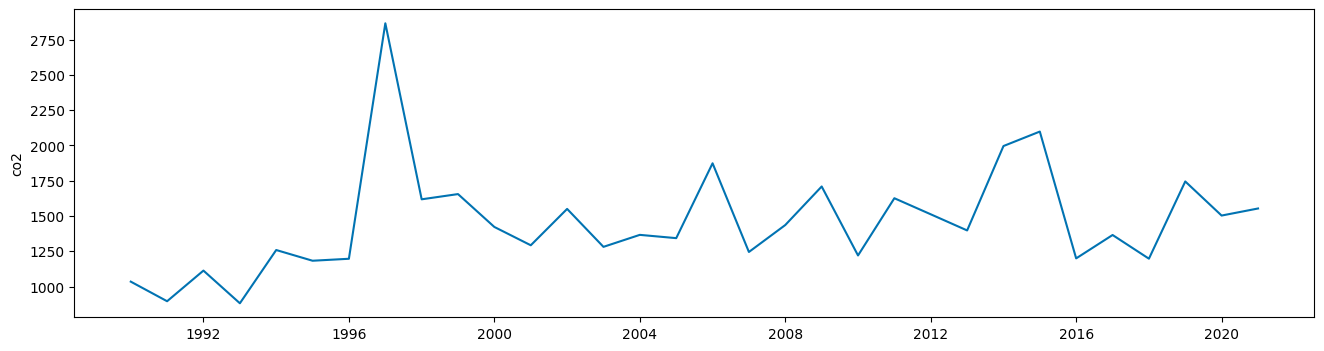

In [23]:
from sktime.utils.plotting import plot_series
plot_series(df, markers=' ')

4. Check for stationarity

In [25]:
from statsmodels.tsa.stattools import adfuller, kpss

adf_result = adfuller(df['co2'])
print(f'ADF p-value: {adf_result[1]}')

kpss_result = kpss(df['co2'], nlags="auto")
print(f'KPSS p-value: {kpss_result[1]}')

ADF p-value: 6.896488810282438e-05
KPSS p-value: 0.1


C:\Users\user\AppData\Local\Temp\ipykernel_18144\407295331.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(df['co2'], nlags="auto")


If the ADF and KPSS are contradictory, go to 5. If not, go to 8.

5. Differentiate and detrend

In [11]:
from sklearn.linear_model import LinearRegression

df['diff'] = df['co2'] - df['co2'].shift(1)
df['log_co2'] = np.log(df['co2'])
df['log_diff'] = df['log_co2'] - df['log_co2'].shift(1)

# Create a time index for regression
time = np.arange(len(df)).reshape(-1, 1)

# Fit a linear regression model to the data
model = LinearRegression()
model.fit(time, df['co2'])

# Subtract the trend
df['detrended'] = df['co2'] - model.predict(time)

6. Apply Box-Cox Transformation

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='co2'>)

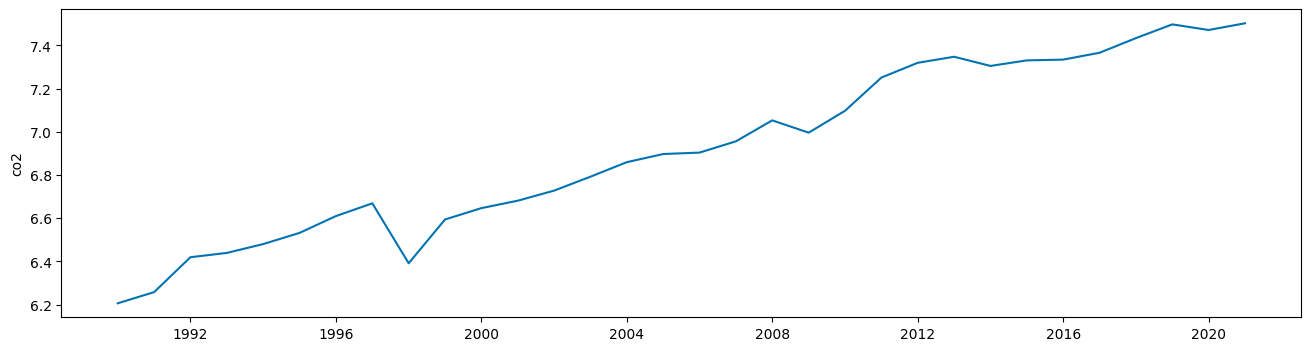

In [12]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

#df['production'], fitted_lambda = boxcox(df['production'], lmbda=None)
df['co2'] = boxcox(df['co2'], lmbda=0)
plot_series(df['co2'], markers=' ')

7. Recheck stationarity

In [13]:
adf_result = adfuller(df['co2'])
print(f'ADF p-value: {adf_result[1]}')

kpss_result = kpss(df['co2'], nlags="auto")
print(f'KPSS p-value: {kpss_result[1]}')

ADF p-value: 0.7317593600932142
KPSS p-value: 0.01


C:\Users\user\AppData\Local\Temp\ipykernel_18144\2201105583.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df['co2'], nlags="auto")


8. Decompose

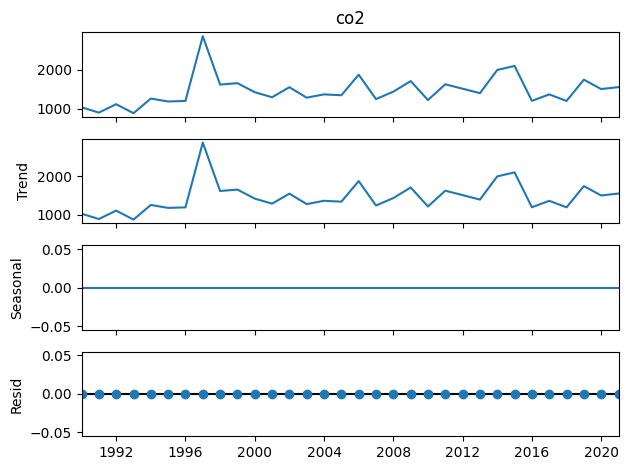

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

result = seasonal_decompose(df['co2'], model='additive', period=1)
result.plot()
plt.show()

If the ADF and KPSS are contradictory, go to 10. Otherwise, go to 9.

9. Apply Box-Cox Transformation

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='co2'>)

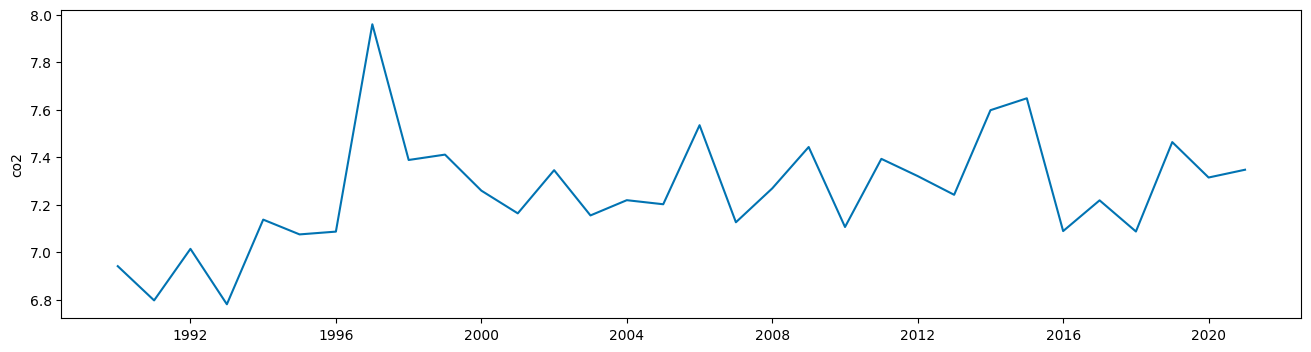

In [27]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

#df['production'], fitted_lambda = boxcox(df['production'], lmbda=None)
df['co2'] = boxcox(df['co2'], lmbda=0)
plot_series(df['co2'], markers=' ')

10. Split data for training and testing

In [28]:
from sktime.split import temporal_train_test_split

train, test = temporal_train_test_split(df, test_size=7)
train.head(), test.head()

(                 co2
 1990-01-01  6.941887
 1991-01-01  6.797727
 1992-01-01  7.014802
 1993-01-01  6.781389
 1994-01-01  7.137964,
                  co2
 2015-01-01  7.649004
 2016-01-01  7.089702
 2017-01-01  7.219155
 2018-01-01  7.087902
 2019-01-01  7.464459)

10. Auto-correlation check

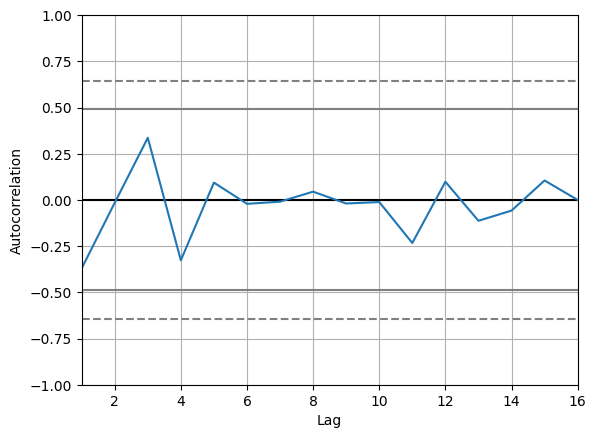

In [29]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train[-16:])

plt.show()

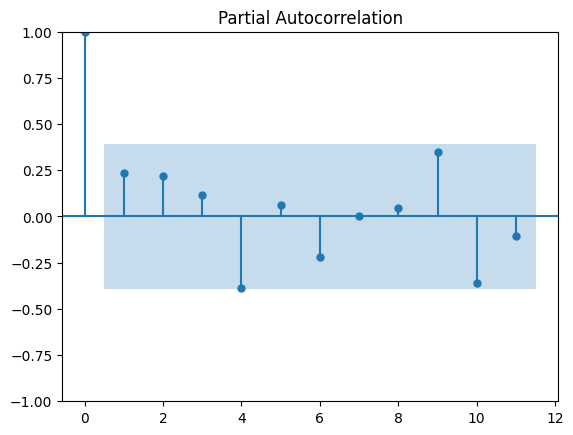

In [30]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train['co2'].squeeze(),lags=11)
plt.show()

11. Fitting the ARIMA model

In [31]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['co2'], order=(3, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                   25
Model:                 ARIMA(3, 1, 0)   Log Likelihood                   0.845
Date:                Thu, 12 Dec 2024   AIC                              6.311
Time:                        13:23:26   BIC                             11.023
Sample:                    01-01-1990   HQIC                             7.561
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6519      0.501     -1.300      0.194      -1.635       0.331
ar.L2         -0.1598      0.415     -0.385      0.700      -0.973       0.653
ar.L3          0.1962      0.246      0.798      0.4

12. Check model residuals

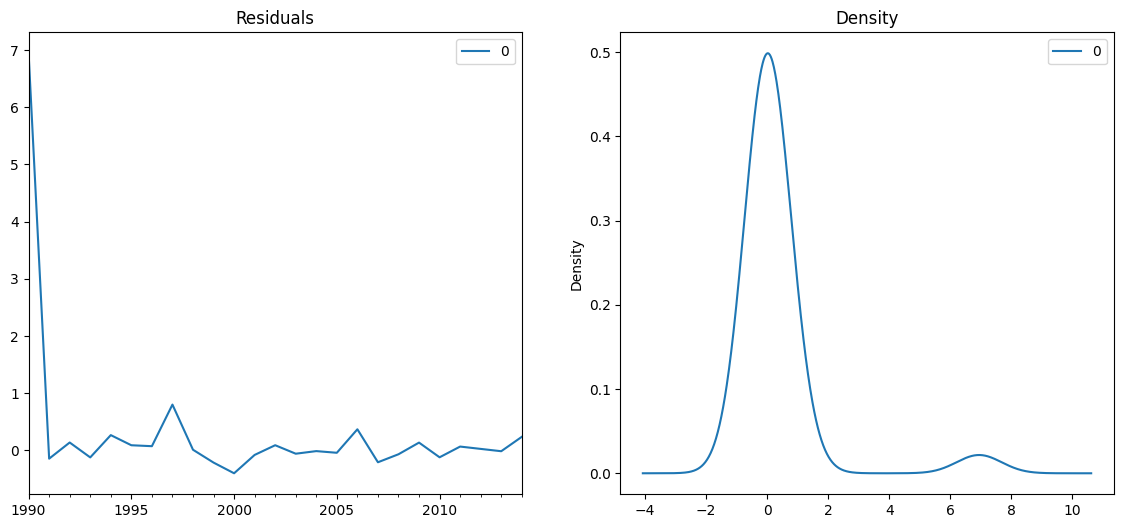

In [32]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

13. Forecast

C:\Users\user\AppData\Local\Temp\ipykernel_18144\3323089877.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = predictions.copy()


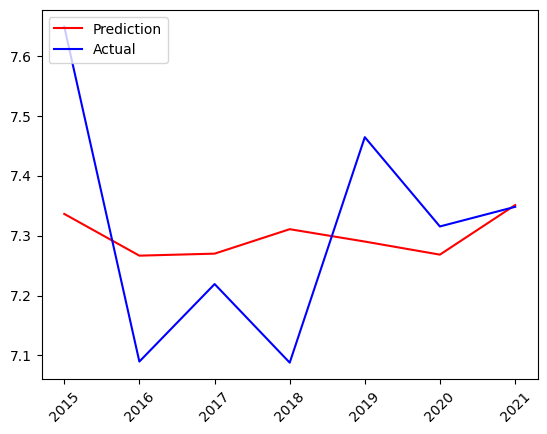

In [33]:
history = train
predictions = list()

for t in range(len(test), 0, -1):
    model = ARIMA(history['co2'][:-t], order=(3, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output.iloc[0]
    predictions.append(yhat)

test['predictions'] = predictions.copy()
plt.plot(test['predictions'], color='red', label='Prediction')
plt.plot(test['co2'], color='blue', label='Actual')
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()

14. Find RMSE

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test['predictions'], test['co2']))
print(f'Test RMSE: {rmse:.3f}')

Test RMSE: 0.175
